In [1]:
#import os
#os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import math
import diffusion_pde as dpde
from diffusion_pde.pdes import generate_heat
import numpy as np
import matplotlib.pyplot as plt
import torch
import h5py
from tqdm.auto import tqdm
from omegaconf import OmegaConf

from pathlib import Path    

In [2]:
def plot_ground_truth(A, U, alpha, T):
    vmin, vmax = min(A.min(), U.min()), max(A.max(), U.max())
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    im0 = axs[0].imshow(A, cmap="viridis", vmin=vmin, vmax=vmax)
    axs[0].set_title(f"Initial Condition: $\\alpha={alpha:.2f}$")
    im1 = axs[1].imshow(U, cmap="viridis", vmin=vmin, vmax=vmax)
    axs[1].set_title(f"Solution at t={T:.2e}")
    fig.colorbar(im1, ax=axs[1])
    plt.tight_layout()
    plt.show()

def plot_sampling_losses(losses, num_steps):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(losses[:, :3])
    axs[0].set(xlabel='sampling step', ylabel='loss', title="Losses During Sampling")
    axs[0].grid()
    axs[1].plot(losses[:, 3])
    axs[1].set(xlabel='sampling step', ylabel='combined loss', title="Combined Loss During Sampling")
    axs[1].grid()
    for i in range(2):
        temp_min, temp_max = axs[i].get_ylim()
        axs[i].vlines(0.8 * num_steps, ymin=temp_min, ymax=temp_max, color='red', linestyle='--')
    axs[0].legend(['obs_a', 'obs_u', 'pde', 'obs weight drop ($\\times 0.1$)'])
    plt.show()

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [37]:
NUM_TEST_SAMPLES = 3
T_STEPS = 10
SEED = 3
spacing_fn = lambda start, stop, num_steps: torch.logspace(math.log10(start + 1e-4), math.log10(stop), num_steps)
#spacing_fn = torch.linspace

t_steps = spacing_fn(0, T, T_STEPS + 1)
dt = t_steps[1:] - t_steps[:-1]

In [38]:
Us, As, t_steps, labels = generate_heat(
    N=NUM_TEST_SAMPLES,
    B=5,
    S=S,
    steps=T_STEPS,
    dt=dt,
    Lx=Lx,
    Ly=Ly,
    device="cuda",
    ic_seed=SEED
)

In [39]:
Us.shape

(3, 1, 64, 64, 11)

In [40]:
Us.min(), Us.max(), As.min(), As.max()

(np.float32(-0.51943856),
 np.float32(1.1242471),
 np.float32(-0.51943856),
 np.float32(1.1242471))

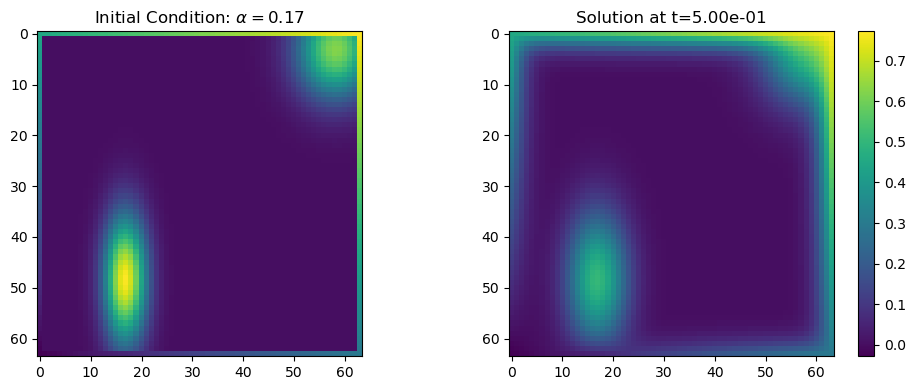

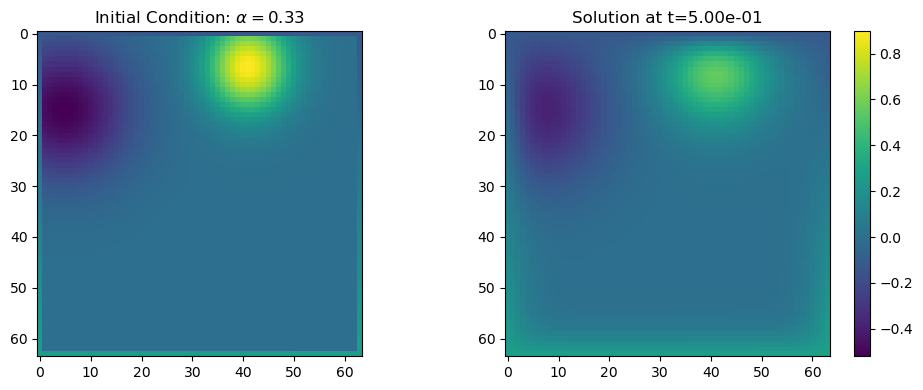

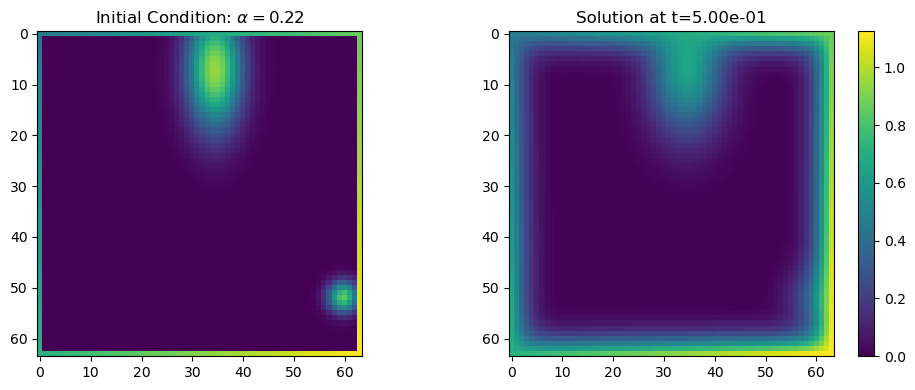

In [41]:
for i in range(NUM_TEST_SAMPLES):
    plot_ground_truth(As[i, 0], Us[i, 0, :, :, 5], float(labels[i].squeeze()), float(t_steps[-1]))

In [121]:
Us = torch.tensor(Us) if not isinstance(Us, torch.Tensor) else Us
As = torch.tensor(As) if not isinstance(As, torch.Tensor) else As
labels = torch.tensor(labels) if not isinstance(labels, torch.Tensor) else labels
t_steps = torch.tensor(t_steps) if not isinstance(t_steps, torch.Tensor) else t_steps

In [122]:
print(f"dtypes: Us: {Us.dtype}, As: {As.dtype}, labels: {labels.dtype}, t_steps: {t_steps.dtype}")

dtypes: Us: torch.float32, As: torch.float32, labels: torch.float32, t_steps: torch.float64


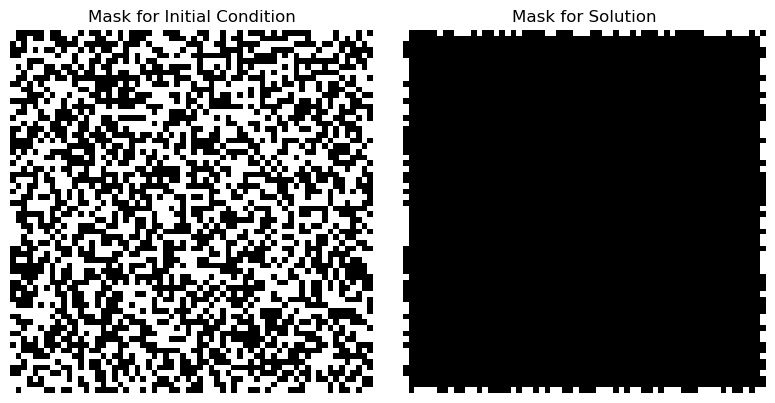

In [123]:
sample_shape = (32, 2, 64, 64)

boundary_obs = dpde.validation.random_boundary_mask(sample_shape[2], sample_shape[3], frac_obs=0.5)
interior_obs_a = dpde.validation.random_interior_mask(sample_shape[2], sample_shape[3], frac_obs=0.5)
interior_obs_u = dpde.validation.random_interior_mask(sample_shape[2], sample_shape[3], frac_obs=0.0)

mask_a = dpde.validation.combine_masks(boundary_obs, interior_obs_a)
mask_u = dpde.validation.combine_masks(boundary_obs, interior_obs_u)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
im0 = axs[0].imshow(mask_a.cpu(), cmap="gray", vmin=0, vmax=1)
axs[0].set_title("Mask for Initial Condition")
im1 = axs[1].imshow(mask_u.cpu(), cmap="gray", vmin=0, vmax=1)
axs[1].set_title("Mask for Solution")
for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()

In [124]:
dx = Lx / (S - 1)
ch_a = 1

zeta_a = 20.0
zeta_u = 5.0
zeta_pde = 1.0
 
num_steps = 50

In [125]:
alpha = float(data_labels[0, 0])
a_lbl = torch.full((sample_shape[0], 1), alpha)
a1 = torch.tensor(data_labels[0])
a_lbl1 = a1.repeat(sample_shape[0], 1)

a_lbl2 = a1.expand(sample_shape[0], -1)
assert torch.all(a_lbl.squeeze() == a_lbl2), "Labels do not match!"
assert torch.all(a_lbl.squeeze() == a_lbl1), "Labels do not match!"

In [126]:
errors = np.zeros((NUM_TEST_SAMPLES, t_steps.shape[0], sample_shape[0], 2))
IS_NAN = False
with tqdm(total=NUM_TEST_SAMPLES, desc="Validating samples", position=0, leave=True) as pbar:

    for i in range(NUM_TEST_SAMPLES):
        if IS_NAN:
            print("Aborting validation due to NaN values in previous samples.")
            break
        lbl = labels[i]
        a_lbl = lbl.unsqueeze(0).expand(sample_shape[0], -1)
        for j in tqdm(range(t_steps.shape[0]), desc=f"Time steps {i+1}/{NUM_TEST_SAMPLES}", position=1, leave=False):
            obs_a = As[i]
            obs_u = Us[i, ..., j]
            obs = torch.cat([obs_a, obs_u], dim=0)
            loss_fn_kwargs = {
                "obs_a": obs_a,
                "obs_u": obs_u,
                "mask_a": mask_a,
                "mask_u": mask_u,
                "dx": dx,
                "dy": dx,
                "ch_a": ch_a,
                "labels": a_lbl,
            }
            t_lbl = t_steps[j].unsqueeze(0).expand(sample_shape[0], -1)
            lbls = torch.cat([t_lbl, a_lbl], dim=1).to(device)

            samples, losses = dpde.sampling.edm_sampler(
                net=edm,
                device=device,
                sample_shape=sample_shape,
                loss_fn=dpde.sampling.heat_loss,
                loss_fn_kwargs=loss_fn_kwargs,
                labels=lbls,
                zeta_a=zeta_a,
                zeta_u=zeta_u,
                zeta_pde=zeta_pde,
                num_steps=num_steps,
                to_cpu=True,
                return_losses=True,
                debug=False,
            )   # output shape (batch, ch, H, W)

            if torch.any(torch.isnan(samples)):
                print(f"NaN values found in samples for test sample {i}, time step {j}")
                IS_NAN = True
                plot_ground_truth(obs_a.squeeze().cpu().numpy(), obs_u.squeeze().cpu().numpy(), float(lbl.squeeze().cpu()), float(t_steps[j].cpu()))
                plot_sampling_losses(losses, num_steps)
                break
                
            errors[i, j, :] = torch.mean((samples - obs.unsqueeze(0)) ** 2, dim=(2, 3)).detach().cpu().numpy()
        pbar.update(1)

Validating samples:   0%|          | 0/2 [00:00<?, ?it/s]

Time steps 1/2:   0%|          | 0/11 [00:00<?, ?it/s]

Time steps 2/2:   0%|          | 0/11 [00:00<?, ?it/s]

In [127]:
np.sum(np.isinf(errors))

np.int64(0)

In [128]:
mse = np.mean(errors, axis=2)
rmse = np.sqrt(mse)
mse.min(), mse.max(), rmse.min(), rmse.max()

(np.float64(0.0013606728207378183),
 np.float64(0.07023092824965715),
 np.float64(0.036887298908131215),
 np.float64(0.26501118514065997))

In [129]:
mu = rmse.mean(axis=0)
std = rmse.std(axis=0)

In [130]:
mu

array([[0.06705892, 0.14715588],
       [0.07106717, 0.08686239],
       [0.07282924, 0.11735418],
       [0.07089729, 0.14322103],
       [0.06929685, 0.1574358 ],
       [0.06816613, 0.16342016],
       [0.0676557 , 0.16609794],
       [0.06722436, 0.16743367],
       [0.0669283 , 0.16833185],
       [0.06631114, 0.16920438],
       [0.06541883, 0.17013149]])

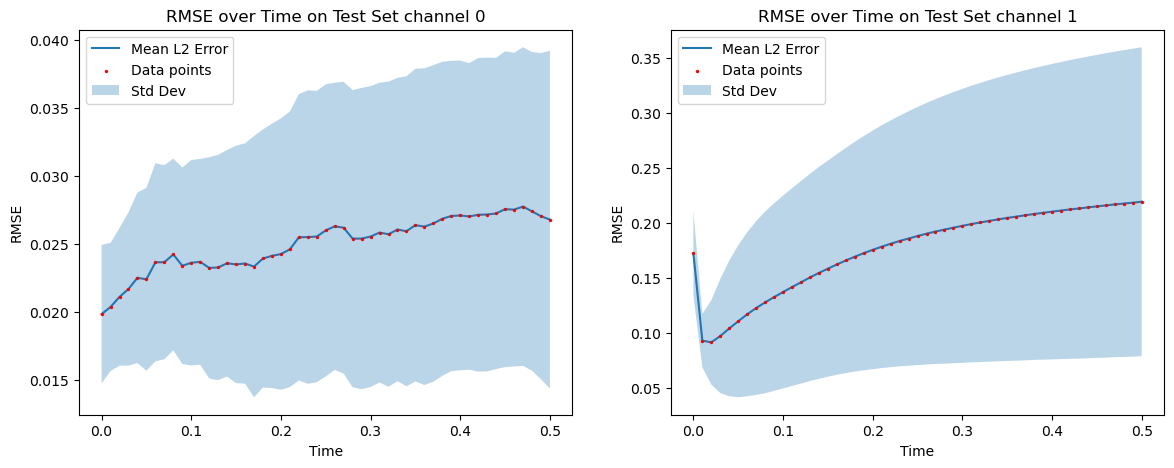

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
for i, ax in enumerate(axs.flat):
    ax.plot(t_steps.numpy(), mu[:, i], label="Mean L2 Error", zorder=2)
    ax.scatter(t_steps.numpy(), mu[:, i], label="Data points", c="red", s=2, zorder=3)
    ax.fill_between(
        t_steps.numpy(),
        mu[:, i] - std[:, i],
        mu[:, i] + std[:, i],
        alpha=0.3,
        label="Std Dev",
        zorder=1
    )
    ax.set(title=f"RMSE over Time on Test Set channel {i}", xlabel="Time", ylabel="RMSE")
    ax.legend()
#plt.savefig(root_path / "logs" / "figures" / f"{data_name}_rmse_over_time.png", dpi=300)
plt.show()